In [2]:
import warnings
warnings.filterwarnings("ignore")
from utils import *  

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

seed = 123
np.set_printoptions(4)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [3]:
max_cycle = 400

In [4]:
X = pd.read_csv("data.csv")
X = check_duplicates_and_constants(X)
X["cycle"] -= 1

y = X.groupby("id")["cycle"].transform(lambda x: x == max(x)).astype(np.uint8)

Initial train shape: (16138, 25)
Duplicates in train: 0
p00 in train set is constant, removed from train set.
p01 in train set is constant, removed from train set.
p07 in train set is constant, removed from train set.
p09 in train set is constant, removed from train set.
p10 in train set is constant, removed from train set.
p16 in train set is constant, removed from train set.
Final train shape: (16138, 19) 

In [5]:
# split by id
np.random.seed(seed)

train_indices = np.random.choice(X["id"].unique(), size=65, replace=False)
x_train, x_valid, y_train, y_valid = X.loc[X["id"].isin(train_indices), :], X.loc[~X["id"].isin(train_indices), :], \
                                     y.loc[X["id"].isin(train_indices)], y.loc[~X["id"].isin(train_indices)]
valid_indices = np.random.choice(x_valid["id"].unique(), size=9, replace=False)
x_valid, x_test, y_valid, y_test = x_valid.loc[x_valid["id"].isin(valid_indices), :], x_valid.loc[~x_valid["id"].isin(valid_indices), :], \
                                   y_valid.loc[x_valid["id"].isin(valid_indices)], y_valid.loc[~x_valid["id"].isin(valid_indices)]
print(f"Train size: {len(y_train)}, validation size: {len(y_valid)} test size: {len(y_test)}")

Train size: 12902, validation size: 1871 test size: 1365


In [68]:
X_val_surv = np.full((x_test["id"].nunique()*max_cycle, x_test.shape[1]-1), fill_value=np.nan)

ids = [26, 33, 48, 56, 58, 67]
k = 0
for i in range(0, len(X_val_surv), max_cycle):
    X_val_surv[i:i+x_test[x_test["id"]==ids[k]].shape[0], :-1] = x_test.loc[x_test["id"]==ids[k], x_test.columns.tolist()[2:]].values
    X_val_surv[i:i+max_cycle, -1] = np.arange(max_cycle)
    k += 1
    
X_val_surv = pd.DataFrame(data=X_val_surv, columns=[col for col in x_test.columns if col not in ('cycle', 'id')]+['cycle'])
for col in X_val_surv.columns:
    X_val_surv[col] = X_val_surv[col].fillna(method='ffill')

In [75]:
cycle = X_val_surv.pop("cycle")
X_val_surv = pd.concat([cycle, X_val_surv], axis=1)

In [107]:
y_val_surv = np.zeros(len(X_val_surv))

for i, engine in enumerate([26, 33, 48, 56, 58, 67]):
    pad_length = X[X["id"] == engine].shape[0]
    y_val_surv[pad_length+i*max_cycle:(i+1)*max_cycle] = 1

In [72]:
x_train.set_index("id", inplace=True)
x_valid.set_index("id", inplace=True)
x_test.set_index("id", inplace=True)

In [81]:
cat = CatBoostRegressor(depth=6, 
                        iterations=1000, 
                        use_best_model=True, 
                        allow_writing_files=False,
                        learning_rate=0.03,
                        verbose=100,
                        loss_function='Poisson').fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds=30)

0:	learn: 0.8353466	test: 0.8346380	best: 0.8346380 (0)	total: 45.2ms	remaining: 45.1s
100:	learn: 0.0094853	test: 0.0133946	best: 0.0133439 (93)	total: 4.75s	remaining: 42.3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.01319075083
bestIteration = 127

Shrink model to first 128 iterations.


In [109]:
p_test_hz = cat.predict(X_val_surv).reshape(-1,max_cycle)
p_test = 1-np.exp(-np.cumsum(p_test_hz, axis=1))

In [110]:
t_test = y_val_surv.reshape(-1,max_cycle)

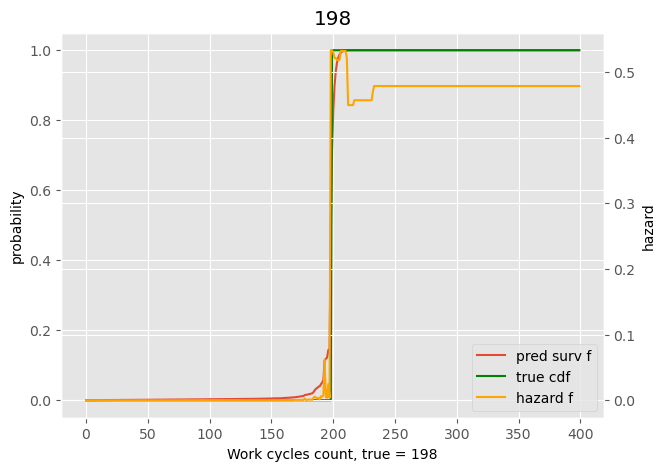

In [125]:
_id = 0

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count, true = {p_test_hz[_id].argmax()}')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()

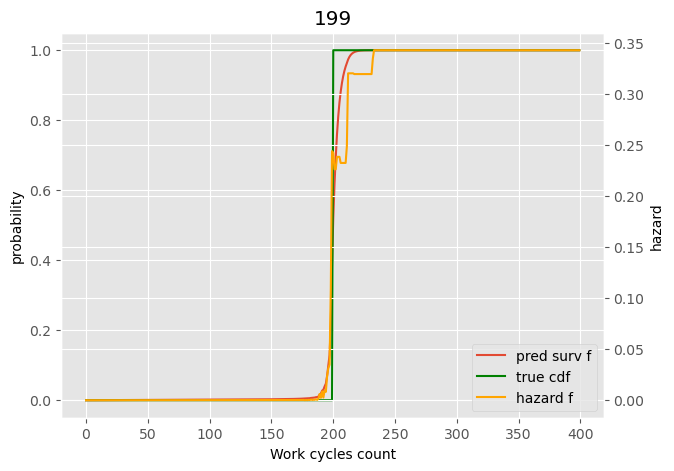

In [132]:
_id = 1

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()

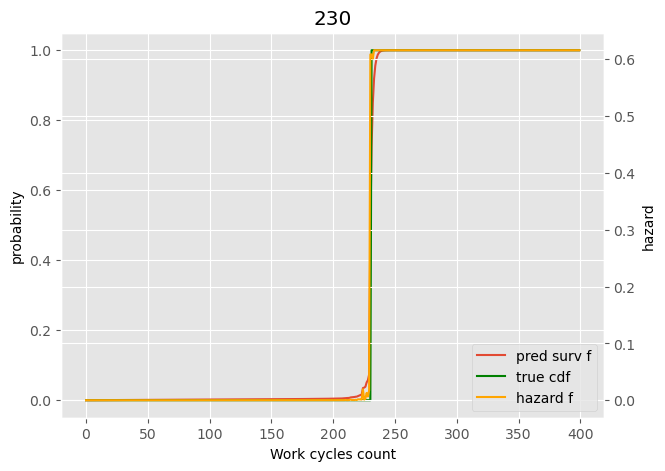

In [133]:
_id = 2

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()

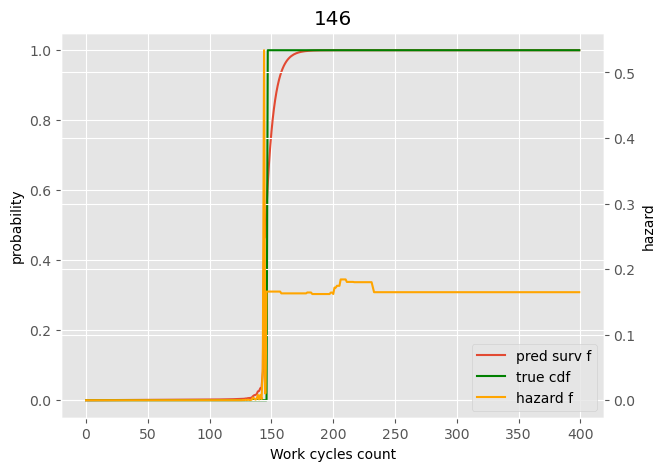

In [134]:
_id = 4

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()

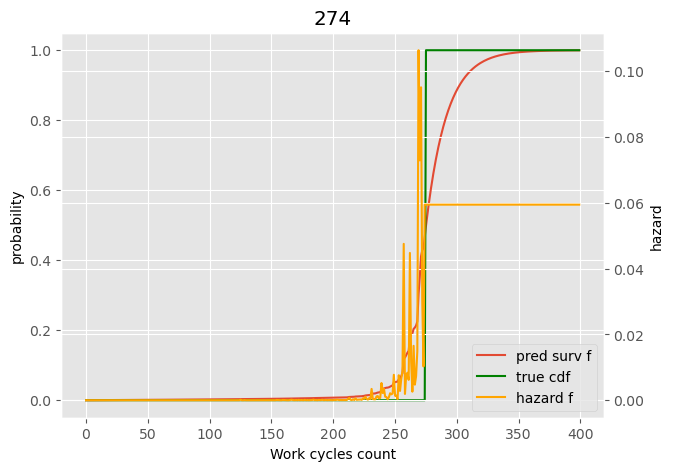

In [135]:
_id = 3

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()

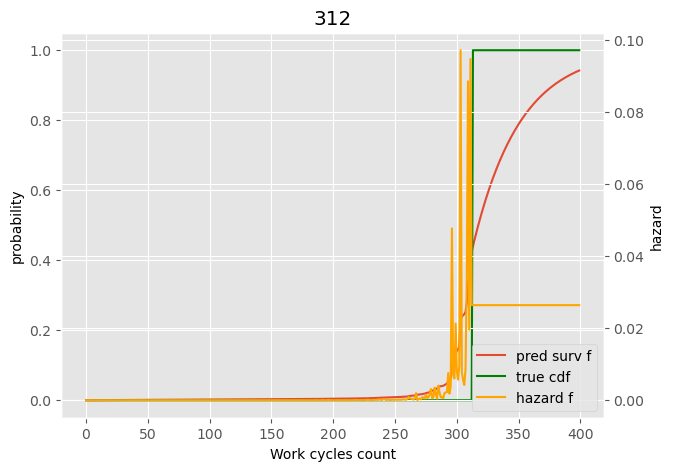

In [137]:
_id = 5

plt.figure(figsize=(7,5))
pred_surv = plt.plot(p_test[_id])
true_cdf = plt.plot(t_test[_id], c='green')
plt.title(f"{y_val_surv[_id*400:((_id+1)*400)].argmax()-1}")
plt.ylabel('probability')
plt.xlabel(f'Work cycles count')
plt.twinx()
pred_haz = plt.plot(p_test_hz[_id], c='orange')
plt.ylabel('hazard')
plt.legend(pred_surv+true_cdf+pred_haz, 
           ['pred surv f', 'true cdf', 'hazard f'], loc='lower right')
plt.show()